In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import aup

In [2]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

In [3]:
cities = [c for c in df.columns.unique()]
# Creates empty GeoDataFrame to store specified municipality polygons
mun_gdf = gpd.GeoDataFrame()
#ageb_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()

In [4]:
year = 2020
mpos_folder = f'mpos_{year}'
c = cities[0]
c = 'Guadalajara'
for i in range(len(df.loc["mpos", c])):
    # Extracts specific municipality code
    m = df.loc["mpos", c][i]
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    aup.log(f"Downloaded {m} GeoDataFrame at: {c}")
    #Creates query to download hex bins
    query = f"SELECT * FROM processed.hex_bins_index_{year} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
    aup.log(f"Donwloaded hex bins for {m}")

In [5]:
gdf = mun_gdf.copy()
gdf = gdf.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve(by='index')['geometry'][0].to_wkt()
schema = 'osmnx'
edges_query =  f"SELECT * FROM {schema}.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(edges_query, geometry_col='geometry')


In [6]:

nombre = c

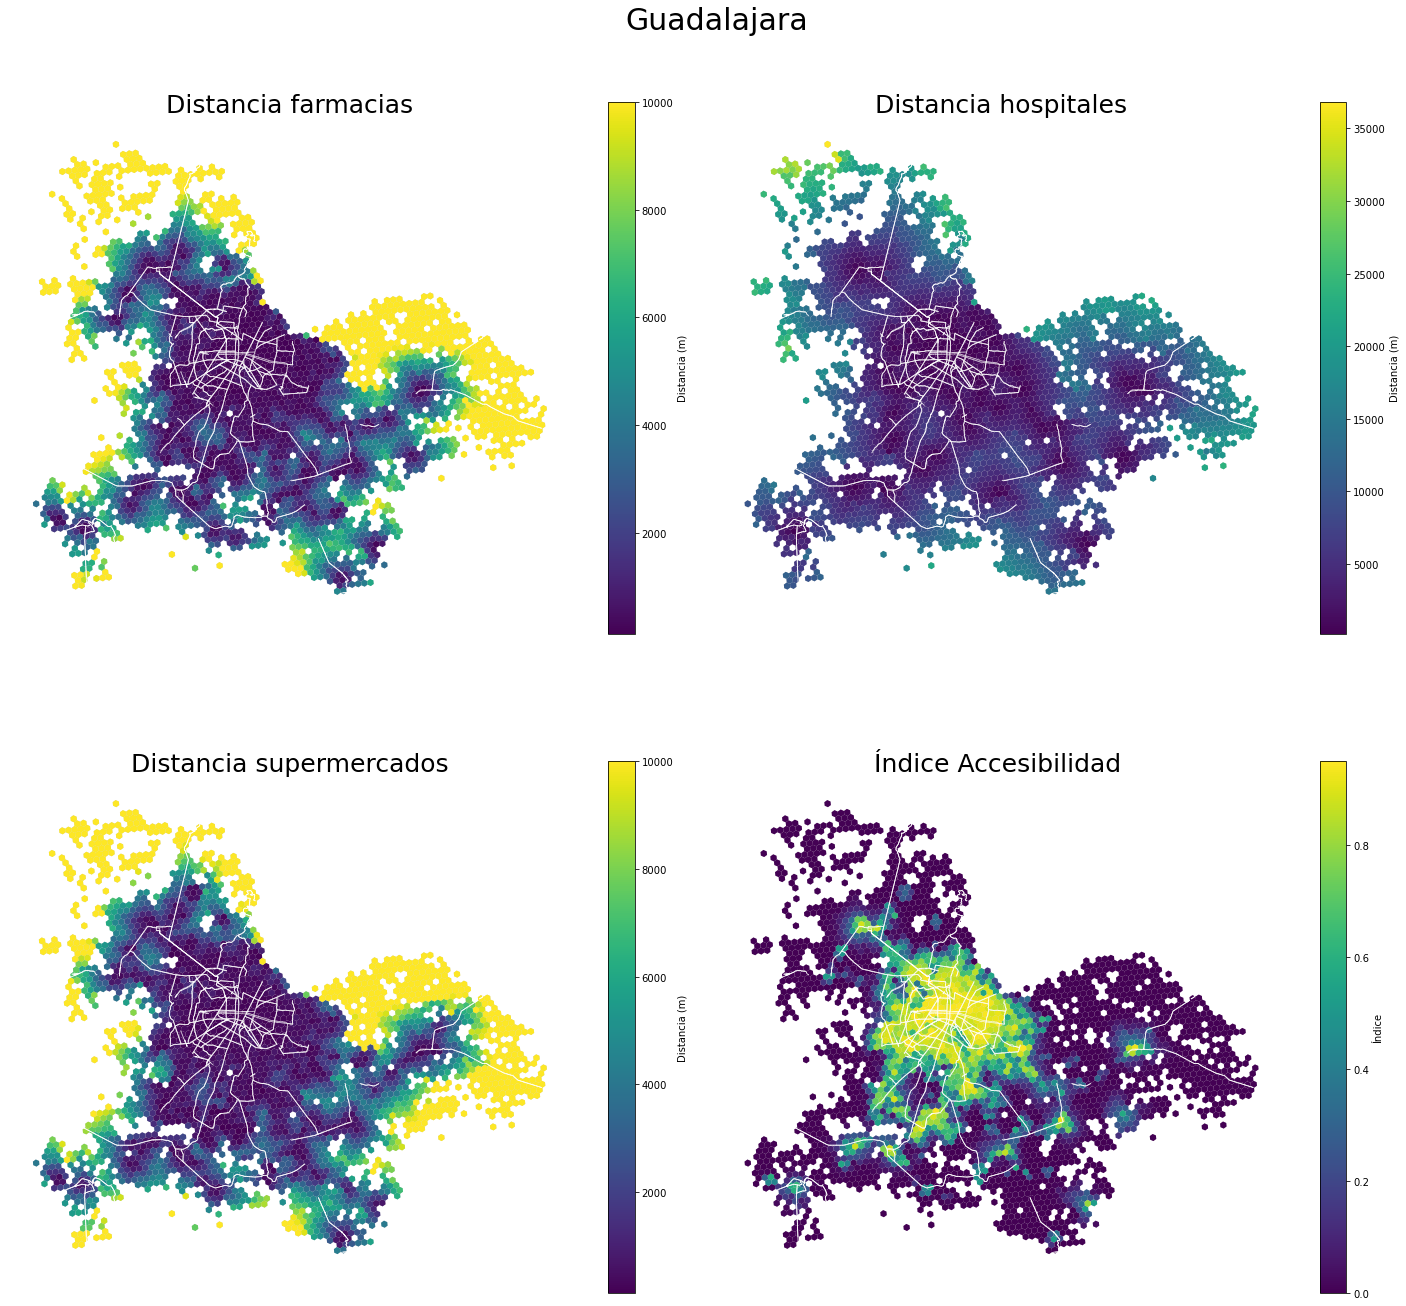

In [7]:
ax_title_size = 25
fig_title_size = 30
secondary_label_size = 15
fig, axes = plt.subplots(2,2,figsize=(20,20))
measures = ['dist_farmacia','dist_hospitales','dist_supermercados','idx_accessibility']
for ax, measure in zip(axes.flat,measures):
    hex_bins.plot(color='lightgrey',ax=ax,zorder=0)
    if measure == 'idx_accessibility':
        legend_kwds = {'shrink': 0.7,'label': 'Índice'}
    else:
        legend_kwds = {'shrink': 0.7,'label': 'Distancia (m)'}
    hex_bins.plot(column=measure,ax=ax,zorder=1, legend=True,legend_kwds=legend_kwds)
    edges[edges['highway'].isin(['primary','primary_link','secondary','secondary_link'])].plot(color='white', ax=ax, zorder=2, linewidth=0.8)
    title = measure.replace('dist_','Distancia ').replace('idx_accessibility','Índice Accesibilidad ').replace('farmacia','farmacias')
    ax.set_title(f'{title}',fontsize=ax_title_size)
    ax.axis('off')
fig.suptitle(nombre,fontsize=fig_title_size, y=0.98)
fig.tight_layout()
plt.savefig(f"../output/figures/{year}/{year}_{nombre.replace(' ','-')}.png", bbox_inches='tight',dpi=300)